# DOCUMENT GUIDE

### The top section of this document is the report.  The charts at the top don't work unless those cells are run last (i.e. after the code in the bottom section).

### The bottom section is the code.  To go directly to the code, scroll down until you see 'CODE STARTS HERE' in bold.

---

---

### Lincoln Anderson - Data Science Capstone - Final Report

# Zip Code Targeting for Future QuikTrip Locations in Raleigh, NC based on Charlotte, NC data


---

## Executive Summary

#### The goal of this research was to predict which zip codes in Raleigh, NC would be good targets for future QuikTrip locations based on a k-nearest neighbors algorithm using nearby venue data from successful Charlotte, NC locations.


#### The goal was not achieved.  The venue patterns in the two areas were too disimilar to generate useful predictions even after several attempts at preparing the data.

---

## Introduction and Business Problem

### A. Company & Audience

#### QuikTrip Corporation (QT) is a convenience/gasoline retailer headquartered in Tulsa, Oklahoma.  QT operates approximately 850 stores in eleven states.  Their strategy is to be the dominant convenience/gasoline retailer in each market they enter through key, high-volume locations. 

#### The stakeholders that will benefit from this research are the executives responsible for expanding QT's footprint into new markets. Currently, QT has 36 locations in the North Carolina market - all in the greater Charlotte area.

### B.Problem

#### The business problem that my research will address is where to place the first few stores as QT expands into the Raleigh NC market.

#### Data from the Charlotte area will be used to project which areas in Raleigh should be considered as possible targets.  The goal will be to determine which zip codes in Raleigh should be considered. 

### C.Background

#### QT frequently closes an existing store in order to open a new store across the street or just down the block.  This willingness to invest in the expense of a move just to achieve a slight change in physical location demonstrates their commitment to operating only in key, high-volume locations. (It is also the justification for assuming older stores are profitable - otherwise, they would already have been closed.  See "assumptions" section below.)

### D. Assumptions

#### Our research is based on several assumptions that might not be true.

#### First, we assume the Raleigh market is similar to the Charlotte market such that a Charlotte-based model would have predictive value in Raleigh.

#### Second, we do not have access to QT profitability by store data so we must use proxies.  Given QT's aggressive location management, we assume older stores are profitable and include the six oldest stores.  Additionally, there are four Charlotte zip codes that have multiple stores.  We also include these zip codes for a total of 9 zip codes (one zip code met both criteria).  These proxies may not actually be the most profitable locations in Charlotte (but we wouldn't need proxies if we actually worked for QT).

#### Finally, we assume that the Foursquare venue location data will be informative when choosing a location.  It is possible that other data (e.g. income per capita, real estate valuations) would serve us better.


### E. Summary

#### We will not address deeper issues like whether suitable real estate is available at a reasonable price in these areas.  These and other questions related to final location will require further research.  

#### Our goal is to suggest Raleigh zip codes for new QT stores. We are merely identifying the zip codes that should be prioritized when the additional research is conducted.

---

## Data

#### We will create a dataset that includes Foursquare location data for each zip code in Charlotte and each zip code in Raleigh.  This data will focus on compiling the venues that exist in a given zip code including the types of venues and their frequency of appearance in the zip code.  

#### Zip code information will be uploaded from CSV files sourced from public.opendatasoft.com.

In [73]:
char_zip_codes.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,28218,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002,-80.804151"
1,28277,Charlotte,NC,35.054546,-80.817920,-5,1,"35.054546,-80.81792"
2,28290,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002,-80.804151"
3,28213,Charlotte,NC,35.280464,-80.756780,-5,1,"35.280464,-80.75678"
4,28269,Charlotte,NC,35.329235,-80.804860,-5,1,"35.329235,-80.80486"


In [74]:
ral_zip_codes.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,27622,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
1,27621,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
2,27676,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
3,27605,Raleigh,NC,35.788284,-78.653160,-5,1,"35.788284,-78.65316"
4,27624,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"


---

## Methodology

### A. The Plan

#### We decided to use k-nearest neighbors to develop a predictive model using the Charlotte data.  We will use that model to predict desirable Raleigh zip codes.  The zip codes of the nine most profitable locations in Charlotte will have a target label of 1.  All other zip codes will have a target label of 0.

In [75]:
# create map
char_map = folium.Map(location=[char_lat, char_long], zoom_start=11)

# set color scheme for the clusters
rainbow = ['red','blue']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(char_zips['Latitude'], char_zips['Longitude'], char_zips['Zip'], char_zips['Targets']):
    label = folium.Popup(str(poi) + 'Targets' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(char_map)
       
char_map

### B. Execution

#### We built a dataframe for Charlotte.

In [76]:
char_zip_codes.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,28218,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002,-80.804151"
1,28277,Charlotte,NC,35.054546,-80.817920,-5,1,"35.054546,-80.81792"
2,28290,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002,-80.804151"
3,28213,Charlotte,NC,35.280464,-80.756780,-5,1,"35.280464,-80.75678"
4,28269,Charlotte,NC,35.329235,-80.804860,-5,1,"35.329235,-80.80486"


In [77]:
char_venues.head()

,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,28218,35.260020,-80.804151,"Cable, Internet and Phone Bundle Retailer",35.259730,-80.805697,Business Service
1,28218,35.260020,-80.804151,Charlotte Pro Locksmith Service,35.259954,-80.803285,Locksmith
2,28218,35.260020,-80.804151,First Step to Freedom - Charlotte,35.260706,-80.804325,Drugstore
3,28218,35.260020,-80.804151,Best Rate Plumbing,35.261442,-80.806149,Home Service
4,28277,35.054546,-80.817920,Toast of Ballantyne,35.053566,-80.812659,Breakfast Spot


#### We built a dataframe from Raleigh.

In [78]:
ral_zip_codes.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,27622,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
1,27621,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
2,27676,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
3,27605,Raleigh,NC,35.788284,-78.653160,-5,1,"35.788284,-78.65316"
4,27624,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"


In [79]:
ral_venues.head()

,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,27622,35.797692,-78.625265,Circus Family Restaurant,35.800420,-78.624876,Hot Dog Joint
1,27622,35.797692,-78.625265,Watkin's Grill,35.801862,-78.625004,American Restaurant
2,27622,35.797692,-78.625265,Slingshot Coffee Co. Weekend,35.798141,-78.624023,Coffee Shop
3,27622,35.797692,-78.625265,Shell,35.799265,-78.625596,Gas Station
4,27622,35.797692,-78.625265,Real Fitt,35.798994,-78.624262,Gym / Fitness Center


#### At this point we recognized that our first assumption (similarity in the two regions) might be incorrect due to the significant difference in number of venue categories.

In [80]:
print('There are {} unique categories in Charlotte.'.format(len(char_venues['Venue Category'].unique())))
print('There are {} unique categories in Raleigh.'.format(len(ral_venues['Venue Category'].unique())))

There are 145 unique categories in Charlotte.
There are 82 unique categories in Raleigh.


#### We then converted the dataset to a usable format for the model.

In [81]:
char_grouped.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Tennis Court,Thai Restaurant,Theater,Trail,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Targets
0,28201,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0
1,28202,0.0,0.050000,0.0,0.02,0.010000,0.0,0.0,0.01,0.0,...,0.0,0.010000,0.03,0.0,0.0,0.000000,0.0,0.000000,0.0,0
2,28203,0.0,0.058824,0.0,0.00,0.029412,0.0,0.0,0.00,0.0,...,0.0,0.029412,0.00,0.0,0.0,0.029412,0.0,0.029412,0.0,0
3,28204,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,1
4,28205,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,1


#### First, we built a k-nearest neighbors predictive model after resizing the Raleigh data to match the Charlotte data.  This was achieved by adding columns of zeros for venues found in Charlotte but not Raleigh.

#### The best 'k' was determined to be 2.

In [82]:
print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was 0.8260869565217391 with k= 2


#### Unfortunately, this model predicted that none of the Raleigh zip codes were good targets.

In [83]:
ral_target_zips

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Second, we built another k-nearest neighbors model after resizing the Charlotte data to match the Raleigh data.  This was achieved by removing columns from the Charlotte data for venues not found in Raleigh.

#### Unfortunately, this model also predicted that none of the Raleigh zip codes were good targets.

In [84]:
ral_target_zips2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### The original plan did not include logistic regression because this approach tends to overfit data when the dataset includes more features than labeled datapoints.  Nonetheless, we attempted it with the smaller dataframes (i.e. the two where Charlotte was resized to fit Raleigh) to limit this drawback by using fewer features.

#### This model had some success with Charlotted data...

In [85]:
jaccard_score(y_testLR, yhatLR,pos_label=0)

0.5

#### but, unfortunately, it still predicted that none of the Raleigh zip codes were good targets.

In [86]:
LR_ral_zip_recs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [87]:
# create map
ral_map = folium.Map(location=[ral_lat, ral_long], zoom_start=11)

# set color scheme for the clusters
rainbow = ['blue']

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(ral_zips['Latitude'], ral_zips['Longitude'], ral_zips['Zip']):
    label = folium.Popup(str(poi) + 'Targets' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[0],
        fill_opacity=0.7).add_to(ral_map)
       
ral_map

---

## Results

#### Neither of the two k-nearest neighbor models nor the logistic regression model generated a positive identification of a zip code in Raleigh.

#### We have evidence (significantly different feature sets) that our first assumption was incorrect.  A possible test for this would be to find a city with existing locations that is closer in size to Raleigh (although it would be farther away geographically) like Tulsa.

#### Additionally, at least one of the other assumptions is probably false as well (and possibly both).

#### The second assumption (that we had correctly identified profitable locations via the proxies we used) cannot be resolved without access to actual location data.  The challenge with using proxies is that we may have chosen a target set that is partly profitable and partly unprofitable which would mean any model generated from this data would be attempting to attempt profitable locations from an inaccurate target set.

#### The third assumption (that Foursquare location data would be useful for prediction) also cannot be resolved at this time.  It is possible that models based on venue data would not yield useful predictions even given two regions that are similar in numerous ways (geographically, population, etc.).

---

## Discussion

#### My recommendations based on the results are:

#### (1) Given that this analysis can be conducted quickly and cheaply, try again with a city closer in population (and ideally, more similar venue feature set) to Raleigh.  Tulsa would be a possibility to try.

#### (2) If this second analysis fails, a new approach needs to be tried.  


#### One alternative would be to add additional data to the data set.  Population by zip code and per capita income would be high on my list of data to try.  Vehicle traffic pattern data would also be strongly considered.

#### A second alternative would be to drop the venue data completely and focus strictly on other variables like those mentioned for the first alternative.

---

## Conclusion

#### It is possible that all three predictive models predicted that Raleigh has no potentially profitable target zip codes because Raleigh is actually a bad market for QT.  Therefore, expansion into Raleigh should be avoided.

#### However, further analysis should be done before locking in this conclusion.  Suggestions for further analysis were provided in the Discussion section above.


---

---

# **CODE STARTS HERE**

### install and import needed libraries (keeping folium separate since it takes a long time and is not always needed when debugging)

In [1]:
!pip install -U numpy
!pip install -U pandas
!pip install -U scipy==1.4.1
!pip install -U scikit-learn
!pip install -U imbalanced-learn

print('installs finished')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 15.3 MB 16.4 MB/s eta 0:00:01
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.0 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.ut

In [2]:
!conda install -c conda-forge folium=0.5.0 --yes 

print('install finished')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |           1_llvm           5 KB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    _pytorch_select-0.2        |            gpu_0           2 KB
    absl-py-0.12.0             |     pyhd8ed1ab_0          96 KB  conda-forge
    aiohttp-3.7.4              |   py37h5e8e339_0         632 KB  conda-forge
    alsa-lib-1.2.3             |       h516909a_0         560 KB  conda-forge
   

In [3]:
import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

import requests

print('imports done')

imports done


In [4]:
import folium

print('import done')

import done


### get data from CSV files stored in project (previously downloaded from public.opendatasoft.com)

In [5]:
import os, types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
body = client_1d36ca0145664f1a85a3ada0fe09ac99.get_object(Bucket='courseracapstoneproject-donotdelete-pr-o4f3nppwnwuzdt',Key='charlotte.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

char_zip_codes = pd.read_csv(body, sep=';')
char_zip_codes.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,28218,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002,-80.804151"
1,28277,Charlotte,NC,35.054546,-80.817920,-5,1,"35.054546,-80.81792"
2,28290,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002,-80.804151"
3,28213,Charlotte,NC,35.280464,-80.756780,-5,1,"35.280464,-80.75678"
4,28269,Charlotte,NC,35.329235,-80.804860,-5,1,"35.329235,-80.80486"


In [8]:
char_zip_codes.shape

(77, 8)

In [9]:
body = client_1d36ca0145664f1a85a3ada0fe09ac99.get_object(Bucket='courseracapstoneproject-donotdelete-pr-o4f3nppwnwuzdt',Key='raleigh.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ral_zip_codes = pd.read_csv(body, sep=';')
ral_zip_codes.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,27622,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
1,27621,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
2,27676,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"
3,27605,Raleigh,NC,35.788284,-78.653160,-5,1,"35.788284,-78.65316"
4,27624,Raleigh,NC,35.797692,-78.625265,-5,1,"35.797692,-78.625265"


In [10]:
ral_zip_codes.shape

(45, 8)

### drop unused columns

In [11]:
char_zips = char_zip_codes.drop(labels=['City','State','Timezone', 'Daylight savings time flag', 'geopoint'], axis=1, inplace=False)
char_zips.head()

,Zip,Latitude,Longitude
0,28218,35.260020,-80.804151
1,28277,35.054546,-80.817920
2,28290,35.260020,-80.804151
3,28213,35.280464,-80.756780
4,28269,35.329235,-80.804860


In [12]:
ral_zips = ral_zip_codes.drop(labels=['City','State','Timezone', 'Daylight savings time flag', 'geopoint'], axis=1, inplace=False)
ral_zips.head()

,Zip,Latitude,Longitude
0,27622,35.797692,-78.625265
1,27621,35.797692,-78.625265
2,27676,35.797692,-78.625265
3,27605,35.788284,-78.653160
4,27624,35.797692,-78.625265


## Begin process of pulling venue data from Foursquare

In [13]:
# define the dataframe columns
more_column_names = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

# instantiate the dataframe
char_venues = pd.DataFrame(columns=more_column_names)

In [14]:
ral_venues = pd.DataFrame(columns=more_column_names)

In [15]:
# The code was removed by Watson Studio for sharing.

In [16]:
VERSION = '20180605'
LIMIT = 100 

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Zip Latitude', 
                  'Zip Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)        
        
        

In [18]:
char_venues = getNearbyVenues(names=char_zips['Zip'],
                                   latitudes=char_zips['Latitude'],
                                   longitudes=char_zips['Longitude']
                                  )

28218
28277
28290
28213
28269
28243
28234
28261
28219
28260
28229
28256
28205
28207
28286
28262
28228
28227
28208
28223
28270
28215
28209
28202
28255
28221
28230
28274
28273
28278
28287
28296
28266
28231
28226
28244
28201
28203
28283
28220
28217
28214
28204
28240
28285
28275
28235
28246
28232
28224
28206
28282
28289
28236
28265
28288
28281
28258
28222
28233
28225
28297
28210
28250
28242
28237
28280
28299
28211
28247
28254
28272
28284
28241
28216
28253
28212


In [19]:
ral_venues = getNearbyVenues(names=ral_zips['Zip'],
                                   latitudes=ral_zips['Latitude'],
                                   longitudes=ral_zips['Longitude']
                                  )

27622
27621
27676
27605
27624
27625
27661
27601
27690
27615
27699
27613
27675
27627
27626
27608
27610
27611
27640
27612
27635
27629
27602
27561
27656
27628
27614
27695
27606
27698
27668
27607
27604
27619
27697
27650
27634
27658
27636
27616
27623
27603
27617
27609
27620


In [20]:
print(char_venues.shape)
char_venues.head()

(698, 7)


,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,28218,35.260020,-80.804151,"Cable, Internet and Phone Bundle Retailer",35.259730,-80.805697,Business Service
1,28218,35.260020,-80.804151,Charlotte Pro Locksmith Service,35.259954,-80.803285,Locksmith
2,28218,35.260020,-80.804151,First Step to Freedom - Charlotte,35.260706,-80.804325,Drugstore
3,28218,35.260020,-80.804151,Best Rate Plumbing,35.261442,-80.806149,Home Service
4,28277,35.054546,-80.817920,Toast of Ballantyne,35.053566,-80.812659,Breakfast Spot


In [21]:
print(ral_venues.shape)
ral_venues.head()

(312, 7)


,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,27622,35.797692,-78.625265,Circus Family Restaurant,35.800420,-78.624876,Hot Dog Joint
1,27622,35.797692,-78.625265,Watkin's Grill,35.801862,-78.625004,American Restaurant
2,27622,35.797692,-78.625265,Slingshot Coffee Co. Weekend,35.798141,-78.624023,Coffee Shop
3,27622,35.797692,-78.625265,Shell,35.799265,-78.625596,Gas Station
4,27622,35.797692,-78.625265,Real Fitt,35.798994,-78.624262,Gym / Fitness Center


In [22]:
print('There are {} unique categories in Charlotte.'.format(len(char_venues['Venue Category'].unique())))
print('There are {} unique categories in Raleigh.'.format(len(ral_venues['Venue Category'].unique())))

There are 145 unique categories in Charlotte.
There are 82 unique categories in Raleigh.


## analyze each zip code

In [23]:
# one hot encoding
char_onehot = pd.get_dummies(char_venues[['Venue Category']], prefix="", prefix_sep="")

# add zip column back to dataframe
char_onehot['Zip'] = char_venues['Zip'] 
            
# move zip column to the first column
fixed_columns = [char_onehot.columns[-1]] + list(char_onehot.columns[:-1])
char_onehot = char_onehot[fixed_columns]

char_onehot.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Trail,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,28218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,28218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,28218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# one hot encoding
ral_onehot = pd.get_dummies(ral_venues[['Venue Category']], prefix="", prefix_sep="")

# add zip column back to dataframe
ral_onehot['Zip'] = ral_venues['Zip'] 
            
# move zip column to the first column
fixed_columns = [ral_onehot.columns[-1]] + list(ral_onehot.columns[:-1])
ral_onehot = ral_onehot[fixed_columns]

ral_onehot.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bagel Shop,Bakery,...,Soccer Field,Sports Bar,Supermarket,Sushi Restaurant,Tailor Shop,Tennis Court,Trail,Video Game Store,Video Store,Women's Store
0,27622,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27622,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27622,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27622,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,27622,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
char_grouped = char_onehot.groupby('Zip').mean().reset_index()
char_grouped

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Trail,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,28201,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,28202,0.0,0.050000,0.000000,0.020000,0.010000,0.0,0.0,0.01,0.0,...,0.020000,0.0,0.010000,0.030000,0.0,0.0,0.000000,0.0,0.000000,0.0
2,28203,0.0,0.058824,0.000000,0.000000,0.029412,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.029412,0.000000,0.0,0.0,0.029412,0.0,0.029412,0.0
3,28204,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,28205,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,28289,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
72,28290,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
73,28296,0.0,0.057971,0.014493,0.014493,0.000000,0.0,0.0,0.00,0.0,...,0.014493,0.0,0.014493,0.014493,0.0,0.0,0.000000,0.0,0.000000,0.0
74,28297,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0


In [26]:
ral_grouped = ral_onehot.groupby('Zip').mean().reset_index()
ral_grouped

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bagel Shop,Bakery,...,Soccer Field,Sports Bar,Supermarket,Sushi Restaurant,Tailor Shop,Tennis Court,Trail,Video Game Store,Video Store,Women's Store
0,27561,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000,0.000000,0.000000,0.000000
1,27601,0.000,0.000000,0.029412,0.0,0.000000,0.029412,0.000000,0.029412,0.000000,...,0.000000,0.029412,0.000,0.029412,0.000,0.00,0.000,0.000000,0.000000,0.000000
2,27602,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000,0.000000,0.000000,0.000000
3,27603,0.000,0.000000,0.000000,0.0,0.052632,0.000000,0.052632,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000,0.052632,0.105263,0.052632
4,27604,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000,0.000000,0.000000,0.000000
5,27605,0.000,0.111111,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.111111,0.000000,0.000,0.000000,0.000,0.00,0.000,0.000000,0.000000,0.000000
6,27606,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000,0.000000,0.000000,0.000000
7,27607,0.000,0.100000,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.200,0.000000,0.000000,0.000000
8,27608,0.000,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000,0.000000,0.000000,0.000000
9,27609,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000,0.000000,0.000000,0.000000


In [27]:
num_top_venues = 5

for zipc in char_grouped['Zip']:
    stuff = "--- {} ---".format(zipc)
    print(stuff)
    temp = char_grouped[char_grouped['Zip'] == zipc].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

--- 28201 ---
                     venue  freq
0             Home Service  0.25
1                Locksmith  0.25
2         Business Service  0.25
3                Drugstore  0.25
4  New American Restaurant  0.00


--- 28202 ---
                 venue  freq
0  American Restaurant  0.05
1       Sandwich Place  0.04
2           Restaurant  0.04
3           Steakhouse  0.04
4          Pizza Place  0.04


--- 28203 ---
                 venue  freq
0                  Spa  0.06
1  American Restaurant  0.06
2           Steakhouse  0.03
3             Pharmacy  0.03
4   Mexican Restaurant  0.03


--- 28204 ---
                     venue  freq
0  New American Restaurant  0.16
1              Pizza Place  0.16
2         Greek Restaurant  0.05
3           Shipping Store  0.05
4       Mexican Restaurant  0.05


--- 28205 ---
                             venue  freq
0  Southern / Soul Food Restaurant   1.0
1                             Pool   0.0
2                           Lounge   0.0
3             

In [28]:
for zipc in ral_grouped['Zip']:
    stuff = "--- {} ---".format(zipc)
    print(stuff)
    temp = ral_grouped[ral_grouped['Zip'] == zipc].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

--- 27561 ---
                      venue  freq
0                      Pool   1.0
1                       ATM   0.0
2  Mediterranean Restaurant   0.0
3                 Pet Store   0.0
4                      Park   0.0


--- 27601 ---
                venue  freq
0         Coffee Shop  0.09
1             Brewery  0.06
2         Music Venue  0.06
3   Korean Restaurant  0.06
4  Italian Restaurant  0.06


--- 27602 ---
                   venue  freq
0    Martial Arts School   1.0
1            Pizza Place   0.0
2              Pet Store   0.0
3                   Park   0.0
4  Outdoors & Recreation   0.0


--- 27603 ---
            venue  freq
0     Video Store  0.11
1  Cosmetics Shop  0.11
2   Women's Store  0.05
3   Big Box Store  0.05
4   Grocery Store  0.05


--- 27604 ---
                        venue  freq
0                        Pool  0.33
1  Construction & Landscaping  0.33
2                      Bakery  0.33
3                         ATM  0.00
4                 Men's Store  0.00


--

In [29]:
# sort venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
# display top 10 venues for each zip

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
char_venues_sorted = pd.DataFrame(columns=columns)
char_venues_sorted['Zip'] = char_grouped['Zip']

for ind in np.arange(char_grouped.shape[0]):
    char_venues_sorted.iloc[ind, 1:] = return_most_common_venues(char_grouped.iloc[ind, :], num_top_venues)

char_venues_sorted.head()

,Zip,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,28201,Home Service,Locksmith,Business Service,Drugstore,New American Restaurant,Moving Target,Museum,Music Venue,Nail Salon,Paper / Office Supplies Store
1,28202,American Restaurant,Sandwich Place,Restaurant,Steakhouse,Pizza Place,Café,Hotel,Park,Italian Restaurant,Irish Pub
2,28203,Spa,American Restaurant,Steakhouse,Pharmacy,Mexican Restaurant,Chinese Restaurant,Gourmet Shop,Gift Shop,Gas Station,Garden Center
3,28204,New American Restaurant,Pizza Place,Greek Restaurant,Shipping Store,Mexican Restaurant,Liquor Store,Stadium,Chinese Restaurant,Latin American Restaurant,Convenience Store
4,28205,Southern / Soul Food Restaurant,Pool,Lounge,Mexican Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,ATM


In [31]:
# repeat for Raleigh

# create columns according to number of top venues
columns = ['Zip']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ral_venues_sorted = pd.DataFrame(columns=columns)
ral_venues_sorted['Zip'] = ral_grouped['Zip']

for ind in np.arange(ral_grouped.shape[0]):
    ral_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ral_grouped.iloc[ind, :], num_top_venues)

ral_venues_sorted.head()

,Zip,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,27561,Pool,ATM,Mediterranean Restaurant,Pet Store,Park,Outdoors & Recreation,Night Market,Music Venue,Mobile Phone Shop,Men's Store
1,27601,Coffee Shop,Brewery,Music Venue,Korean Restaurant,Italian Restaurant,Ice Cream Shop,Bus Station,Butcher,Seafood Restaurant,Clothing Store
2,27602,Martial Arts School,Pizza Place,Pet Store,Park,Outdoors & Recreation,Night Market,Music Venue,Mobile Phone Shop,Men's Store,Mediterranean Restaurant
3,27603,Video Store,Cosmetics Shop,Women's Store,Big Box Store,Grocery Store,Men's Store,Mobile Phone Shop,Fried Chicken Joint,Fast Food Restaurant,Pharmacy
4,27604,Pool,Construction & Landscaping,Bakery,ATM,Men's Store,Pet Store,Park,Outdoors & Recreation,Night Market,Music Venue


## Data is prepared.  Implement K-nearest neighbors

### create feature set for Charlotte data

In [32]:
char_X = char_grouped.values 
char_X[0:5]

array([[2.82010000e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

### add targets column to Charlotte zip code data then update value to 1 for the nine target zip codes

In [33]:
# create list of target zip codes
targets = [28206, 28208, 28212, 28213, 28216, 28217, 28262, 28269, 28273]

In [34]:
char_grouped["Targets"] = 0
char_grouped.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Tennis Court,Thai Restaurant,Theater,Trail,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Targets
0,28201,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0
1,28202,0.0,0.050000,0.0,0.02,0.010000,0.0,0.0,0.01,0.0,...,0.0,0.010000,0.03,0.0,0.0,0.000000,0.0,0.000000,0.0,0
2,28203,0.0,0.058824,0.0,0.00,0.029412,0.0,0.0,0.00,0.0,...,0.0,0.029412,0.00,0.0,0.0,0.029412,0.0,0.029412,0.0,0
3,28204,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0
4,28205,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0


In [35]:
char_grouped.loc[char_zips.Zip.isin(targets), "Targets"] = 1
char_grouped.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Tennis Court,Thai Restaurant,Theater,Trail,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Targets
0,28201,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0
1,28202,0.0,0.050000,0.0,0.02,0.010000,0.0,0.0,0.01,0.0,...,0.0,0.010000,0.03,0.0,0.0,0.000000,0.0,0.000000,0.0,0
2,28203,0.0,0.058824,0.0,0.00,0.029412,0.0,0.0,0.00,0.0,...,0.0,0.029412,0.00,0.0,0.0,0.029412,0.0,0.029412,0.0,0
3,28204,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,1
4,28205,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,1


In [36]:
char_y = char_grouped['Targets'].values
char_y[0:5]

array([0, 0, 0, 1, 1])

### normalize data

In [37]:
char_X = preprocessing.StandardScaler().fit(char_X).transform(char_X.astype(float))
char_X[0:5]

array([[-1.54852434, -0.11547005, -0.29667902, -0.16432381, -0.20053329,
        -0.18516294, -0.11547005, -0.11547005, -0.16439899, -0.14265366,
        -0.13408633, -0.16451474, -0.24059246, -0.14046939, -0.16163001,
        -0.16439899, -0.11547005, -0.11547005, -0.15145046, -0.16615637,
        -0.20193469, -0.11547005, -0.11547005,  0.79052575, -0.11547005,
        -0.21457775, -0.11547005, -0.11547005, -0.18031288, -0.23089532,
        -0.13818757, -0.22066516, -0.11547005, -0.11547005, -0.11547005,
        -0.11547005, -0.11547005, -0.11547005, -0.11547005, -0.11547005,
        -0.23089532, -0.16112275, -0.17843231, -0.12690981, -0.22900393,
        -0.11547005, -0.22598221, -0.11547005, -0.11547005, -0.11547005,
        -0.11547005,  0.82999331, -0.11547005, -0.11547005, -0.11547005,
        -0.15458529, -0.11547005, -0.11547005, -0.11547005, -0.21643051,
        -0.14931821, -0.11547005, -0.11547005, -0.13028478, -0.16439899,
        -0.11547005, -0.11547005, -0.12235956, -0.2

In [38]:
X_train, X_test, y_train, y_test = train_test_split(char_X, char_y, test_size=0.3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (53, 146) (53,)
Test set: (23, 146) (23,)


### find best value for k

In [39]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.7826087 , 0.82608696, 0.82608696, 0.82608696, 0.82608696,
       0.82608696, 0.82608696, 0.82608696, 0.82608696])

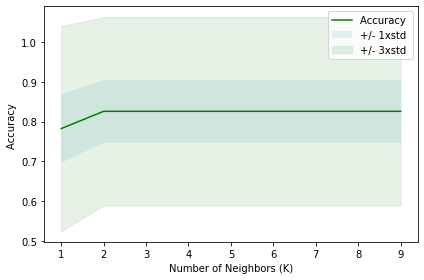

In [40]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [41]:
print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was 0.8260869565217391 with k= 2


### fit model for best K

In [42]:
k = mean_acc.argmax()+1
#Train Model and Predict  

neigh = KNeighborsClassifier(n_neighbors = k).fit(char_X,char_y)
neigh

KNeighborsClassifier(n_neighbors=2)

# use model to predict Raleigh zip codes

### resize Raleigh features to match Charlotte matrix

In [43]:
columns = char_grouped.columns 

feature_list = columns.tolist()

In [44]:
ral_resized = pd.DataFrame(0.0, index=np.arange(len(ral_grouped)), columns=feature_list)

In [45]:
ral_resized.drop(labels="Targets", axis=1, inplace=True)

In [46]:
ral_resized.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Trail,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
ral_resized.shape

(43, 146)

In [48]:
for col in ral_resized:
    if col in ral_grouped:
        ral_resized[col] = ral_grouped[col]
        
ral_resized.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Trail,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,27561,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,27601,0.0,0.0,0.029412,0.0,0.029412,0.0,0.000000,0.0,0.029412,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,27602,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,27603,0.0,0.0,0.000000,0.0,0.000000,0.0,0.052632,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.105263,0.0,0.0,0.052632,0.0
4,27604,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


### resize Charlotte matrix to match Raleigh matrix

In [49]:
columns2 = ral_grouped.columns

feature_list2 = columns2.tolist()

In [50]:
char_resized = pd.DataFrame(0.0, index=np.arange(len(char_grouped)), columns=feature_list2)

char_resized.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bagel Shop,Bakery,...,Soccer Field,Sports Bar,Supermarket,Sushi Restaurant,Tailor Shop,Tennis Court,Trail,Video Game Store,Video Store,Women's Store
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
char_resized.shape

(76, 83)

In [52]:
for col in char_resized:
    if col in char_grouped:
        char_resized[col] = char_grouped[col]
        
char_resized.head()

,Zip,ATM,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bagel Shop,Bakery,...,Soccer Field,Sports Bar,Supermarket,Sushi Restaurant,Tailor Shop,Tennis Court,Trail,Video Game Store,Video Store,Women's Store
0,28201,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000
1,28202,0.0,0.050000,0.0,0.02,0.0,0.010000,0.0,0.0,0.000000,...,0.0,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.000000
2,28203,0.0,0.058824,0.0,0.00,0.0,0.029412,0.0,0.0,0.029412,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.029412
3,28204,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000
4,28205,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000


### rerun k-nearest with resized (smaller) Charlotte matrix

In [53]:
char_resized_X = char_resized.values 
char_resized_X[0:5]

array([[2.82010000e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.50000000e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.50000000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [54]:
char_resized_X = preprocessing.StandardScaler().fit(char_resized_X).transform(char_resized_X.astype(float))
char_resized_X[0:5]

array([[-1.54852434, -0.11547005, -0.29667902, -0.16432381, -0.20053329,
         0.        , -0.18516294, -0.11547005, -0.14265366, -0.13408633,
        -0.16451474,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.15145046,  0.        , -0.16615637, -0.20193469,
        -0.11547005,  0.        , -0.21457775, -0.18031288,  0.        ,
        -0.22066516, -0.23089532, -0.16112275, -0.17843231, -0.12690981,
         0.        , -0.15458529, -0.11547005, -0.11547005, -0.21643051,
        -0.14931821, -0.11547005, -0.11547005, -0.13028478, -0.12235956,
        -0.23089532,  0.82999331,  0.        , -0.22900393, -0.22349062,
        -0.11547005, -0.24059246, -0.2276294 , -0.11547005,  0.        ,
         0.82999331, -0.23309511,  0.        ,  0.        ,  0.        ,
         0.        , -0.12117289,  0.        ,  0.        , -0.25880486,
         0.        , -0.15098552, -0.19857189,  0.        , -0.1920513 ,
         0.        ,  0.        ,  0.        , -0.3

### fit model for k=2

In [55]:
k = 2
#Train Model and Predict  
neigh2 = KNeighborsClassifier(n_neighbors = k).fit(char_resized_X,char_y)
neigh2

KNeighborsClassifier(n_neighbors=2)

### create feature set for Raleigh

In [56]:
ral_X = ral_resized.values 
ral_X[0:5]

array([[2.75610000e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [57]:
ral_X = preprocessing.StandardScaler().fit(ral_X).transform(ral_X.astype(float))
ral_X[0:5]

array([[-2.33787125, -1.1785113 , -1.35498841, -0.15430335, -0.15430335,
        -0.15430335,  0.        , -0.15430335,  0.        , -0.15430335,
        -1.11532546, -0.15430335,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.15430335, -0.15430335,
        -0.15430335, -0.15430335,  0.        ,  0.        ,  0.        ,
        -0.21991205,  0.        ,  0.        , -0.15430335,  0.        ,
         0.        , -1.31078397,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.19340613, -0.2090199 , -0.15430335, -0.22001703,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.15430335, -0.15430335,  0.        , -0.15430335, -0.15430335,
        -0.15430335, -0.15430335, -1.1785113 , -0.15430335,  0.        ,
         0.        ,  0.        , -0.15430335,  0. 

### predict best target zip codes for Raleigh and output list

In [58]:
ral_target_zips = neigh.predict(ral_X)
ral_target_zips

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# show map of Charlotte with targets

In [59]:
char_zips["Targets"] = 0
char_zips.head()

,Zip,Latitude,Longitude,Targets
0,28218,35.260020,-80.804151,0
1,28277,35.054546,-80.817920,0
2,28290,35.260020,-80.804151,0
3,28213,35.280464,-80.756780,0
4,28269,35.329235,-80.804860,0


In [60]:
char_zips.loc[char_zips.Zip.isin(targets), "Targets"] = 1
char_zips.head()

,Zip,Latitude,Longitude,Targets
0,28218,35.260020,-80.804151,0
1,28277,35.054546,-80.817920,0
2,28290,35.260020,-80.804151,0
3,28213,35.280464,-80.756780,1
4,28269,35.329235,-80.804860,1


In [61]:
char_lat = 35.2271
char_long = -80.8431

In [62]:
# create map
char_map = folium.Map(location=[char_lat, char_long], zoom_start=11)

# set color scheme for the clusters
rainbow = ['red','blue']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(char_zips['Latitude'], char_zips['Longitude'], char_zips['Zip'], char_zips['Targets']):
    label = folium.Popup(str(poi) + 'Targets' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(char_map)
       
char_map

### predict best target zip codes in Raleigh with model 2 and output list

In [63]:
ral_X2 = ral_grouped.values 
ral_X2[0:5]

array([[2.75610000e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [64]:
ral_target_zips2 = neigh2.predict(ral_X2)
ral_target_zips2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## logistic regression

In [65]:
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split(char_resized_X, char_y, test_size=0.3)
print ('Train set:', X_trainLR.shape,  y_trainLR.shape)
print ('Test set:', X_testLR.shape,  y_testLR.shape)

Train set: (53, 83) (53,)
Test set: (23, 83) (23,)


In [66]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trainLR,y_trainLR)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [67]:
yhatLR = LR.predict(X_testLR)
yhatLR

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1])

In [68]:
jaccard_score(y_testLR, yhatLR,pos_label=0)

0.5

In [69]:
LR_model = LogisticRegression(C=0.01, solver='liblinear').fit(char_resized_X,char_y)
LR_model

LogisticRegression(C=0.01, solver='liblinear')

In [70]:
LR_ral_zip_recs = LR_model.predict(ral_X2)
LR_ral_zip_recs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# show map of Raleigh with results

In [71]:
ral_lat = 35.7796
ral_long = -78.6382

In [72]:
# create map
ral_map = folium.Map(location=[ral_lat, ral_long], zoom_start=11)

# set color scheme for the clusters
rainbow = ['blue']

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(ral_zips['Latitude'], ral_zips['Longitude'], ral_zips['Zip']):
    label = folium.Popup(str(poi) + 'Targets' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[0],
        fill_opacity=0.7).add_to(ral_map)
       
ral_map